<a href="https://colab.research.google.com/github/thwlruss10/VDA_pipeline/blob/main/GIThub_VQA_Bert_DEiT_trainingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!pip install transformers datasets nltk scikit-learn


In [ ]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import re
import pandas as pd
import os
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models & transformers (ViTModel, DeiTModel, BEiT)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#set_caching_enabled(True)>> this line deleted as 'datasets' no longer supports explicit cahce enabling
#set_caching_enabled(True)
logging.set_verbosity_error()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


[nltk_data] Downloading package wordnet to /root/nltk_data...


Above code imports dependencies, sets cache path for Huggingface transformers, error logs message threshold set to supress warnings deemed not severe. GPU device set for torch processes.

In [ ]:
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split

# Define base directory pointing to your Drive location
base_dir = "/content/drive/MyDrive/FinalProject/dataset"
os.makedirs(base_dir, exist_ok=True)

# Define regex to extract image ID
image_pattern = re.compile(r"( (in |on |of )?(the |this )?(image\d*) \?)")

# Read the raw Q&A file
# Extracts image ID and question at index[i] together with answer at [i+1]
# and organizes it into a pandas DataFrame, creates a list of unique answers,
# and then splits the dataset into training and testing sets, saving them as
# CSV.

qa_file = os.path.join(base_dir, "all_qa_pairs.txt")
with open(qa_file, "r", encoding="utf-8") as f: # open in read mode with in utf-8 encoding
    qa_data = [x.strip() for x in f.readlines()] # x.strip() removes white spaces

records = []
for i in range(0, len(qa_data), 2): # iterates in steps of two because quesiton is at index i and answer at i+1
    match = image_pattern.findall(qa_data[i]) # extract image ID from question string
    if match:
        img_id = match[0][3]
        question = qa_data[i].replace(match[0][0], "").strip() # remove image ID and replace question
        answer = qa_data[i + 1].strip() # answer retrieved from next element
        records.append({"question": question, "answer": answer, "image_id": img_id}) #populate dictionary



df = pd.DataFrame(records)


answer_space = []
for ans in df["answer"].to_list():
    if "," in ans:
        answer_space += ans.replace(" ", "").split(",")
    else:
        answer_space.append(ans)

# sort and remove duplicates from answer_space
answer_space = sorted(set(answer_space))

# Write the answer space to file
with open(os.path.join(base_dir, "answer_space.txt"), "w", encoding="utf-8") as f:
    f.writelines("\n".join(answer_space))

# Split dataset into training and evaluation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save to CSV
train_df.to_csv(os.path.join(base_dir, "data_train.csv"), index=False)
test_df.to_csv(os.path.join(base_dir, "data_eval.csv"), index=False)


In [ ]:
import pandas as pd

base_dir = "/content/drive/MyDrive/FinalProject/dataset"
eval_df = pd.read_csv(os.path.join(base_dir, "data_eval.csv"))


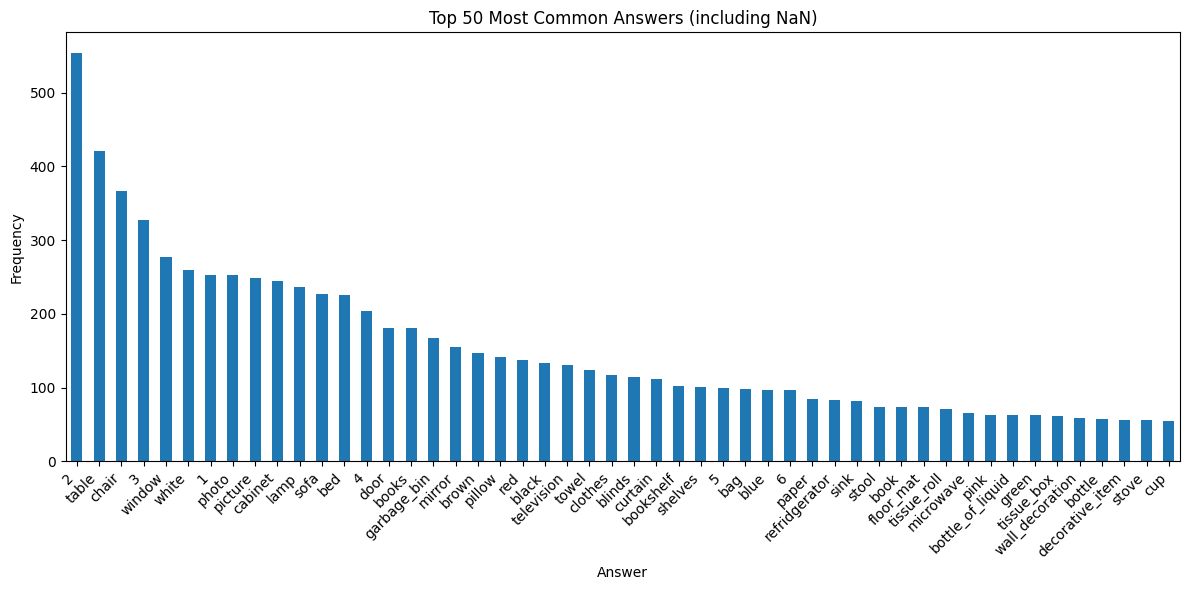

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['answer'] = df['answer'].astype(str).str.strip().str.lower()

# Count frequency of each unique answer, including NaN values
answer_counts = df['answer'].value_counts(dropna=False)

# Plot histogram of top N most common answers (e.g., top 50)
top_n = 50
plt.figure(figsize=(12, 6))
answer_counts[:top_n].plot(kind='bar')
plt.title(f'Top {top_n} Most Common Answers (including NaN)')
plt.xlabel('Answer')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
for i in range(0, 10, 2):  # look at 5 question/answer pairs
    print(f"Q: {qa_data[i]}")
    print(f"A: {qa_data[i+1]}")
    print("-" * 40)


In [ ]:
from datasets import load_dataset
import os

# Define the base directory (your dataset folder in Google Drive)
base_dir = "/content/drive/MyDrive/FinalProject/dataset"

# Load the training & evaluation dataset from CSV files
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join(base_dir, "data_train.csv"),



        "test": os.path.join(base_dir, "data_eval.csv")
    }
)

# Load the list of all possible answers
with open(os.path.join(base_dir, "answer_space.txt"), "r", encoding="utf-8") as f:
    answer_space = f.read().splitlines()

# Map textual answers to label indices (for classification)
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])
            for ans in examples['answer']
        ]
    },
    batched=True
)


In [ ]:
from IPython.display import display
from PIL import Image
import numpy as np
import os

# Set the correct image directory in Google Drive
image_dir = "/content/drive/MyDrive/FinalProject/dataset/images"

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]

    if id is None:
        id = np.random.randint(len(data))

    img_path = os.path.join(image_dir, data[id]["image_id"] + ".png")

    if not os.path.exists(img_path):
        print(f"⚠️ Image not found at: {img_path}")
        return

    print(f"✅ Found image at: {os.path.abspath(img_path)}")
    image = Image.open(img_path)
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], f"(Label: {data[id]['label']})")

# Show a random training example
showExample()


From project prompt:
 EXPLORE ATTENTNION MECHANISMS AND CROSS-MODAL FEATURE FUSION TECHINQUES

In [ ]:
from dataclasses import dataclass
from typing import List, Union
from PIL import Image
import torch
import os

'''
Defines class called mulitmodal collator which encodes/tokenizes text and images.
advance of transformers

__call__ is when the MultimodalCollator is used to prepare a batch of data.
It takes a raw_batch_dict as input, each containing information about a single data point.
It extracts the question, image_id, and label (answer) from the dictionary.
It then calls tokenize_text and preprocess_images to process the text and images,respectively.
Finally, it combines the results into a single dictionary containing the tokenized text,
processed images, and labels, ready to be fed to the model.
'''



@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor
    image_dir: str  # ✅ add image_dir as a configurable path

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'],
            "token_type_ids": encoded_text['token_type_ids'],
            "attention_mask": encoded_text['attention_mask'],
        }

    def preprocess_images(self, images: List[str]):
        # ✅ Read from provided image_dir
        processed_images = self.preprocessor(
            images=[
                Image.open(os.path.join(self.image_dir, image_id + ".png")).convert('RGB')
                for image_id in images
            ],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'],
        }



    def __call__(self, raw_batch_dict: Union[dict, List[dict]]):
        # Normalize format to list of dicts
        if isinstance(raw_batch_dict, dict):
            questions = raw_batch_dict['question']
            image_ids = raw_batch_dict['image_id']
            labels = raw_batch_dict['label']
        else:
            questions = [i['question'] for i in raw_batch_dict]
            image_ids = [i['image_id'] for i in raw_batch_dict]
            labels = [i['label'] for i in raw_batch_dict]

        return {
            **self.tokenize_text(questions),
            **self.preprocess_images(image_ids),
            'labels': torch.tensor(labels, dtype=torch.int64),
        }



In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel
from typing import Optional

'''
The MultimodalVQAModel takes a question and an image as input.
It uses pre-trained models to extract features from both, combines these features,
and then predicts the answer to the question based on the combined information.
This architecture is typical for VQA tasks, where the goal is to understand both
visual and textual information to provide accurate answers.

forward() Defines how the model processes data during training and inference.
  input_ids: Tokenized representation of the question.
  pixel_values: Processed image data.
  attention_mask: Indicates which tokens in the question are relevant.
  token_type_ids: Distinguishes between different segments of text (if applicable).
  labels: The correct answer (used during training).
'''

class MultimodalVQAModel(nn.Module):  #Defining Mu-Mo-VQA model is per PyTorch base class nn.Module
    def __init__(
        self,
        pretrained_text_name: str,
        pretrained_image_name: str,
        num_labels: int,
        intermediate_dim: int = 512,  # increase to reduce overfitting can modify to 1024
        dropout: float = 0.5          # prevents overfitting, can decrease to 0.1.
    ):
        super(MultimodalVQAModel, self).__init__()

        self.num_labels = num_labels  #length of answer space
        self.text_encoder = AutoModel.from_pretrained(pretrained_text_name) # attention mechanism lives in pre-trained transformers
        self.image_encoder = AutoModel.from_pretrained(pretrained_image_name)

        # Fallback if pooler_output doesn't exist (e.g., in ViT)
        self.use_pooler_text = hasattr(self.text_encoder.config, "pooler_fc_size")
        self.use_pooler_image = hasattr(self.image_encoder.config, "pooler_fc_size")

        # Fusion + Classification layers
        # linear transformation, activation function (ReLU), dropout regularization
        # Integrates the combined features comprehensive representation
        self.fusion = nn.Sequential(
            nn.Linear(
                self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size,
                intermediate_dim
            ),
            # nn.BatchNorm1d(intermediate_dim),  # Add Batch Normalization
            nn.ReLU(),            # alt nn.LeakyReLU, nn.GELU, or nn.ELU
            nn.Dropout(dropout),
        )

        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        self.criterion = nn.CrossEntropyLoss()
    # Feed forward fusion
    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):
        # Encode text
        text_output = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        if "pooler_output" in text_output:          # not all pre-trained models have pooling, BERT has
            text_feat = text_output.pooler_output   # model to handle different pre-trained encoders by checking
        else:
            text_feat = text_output.last_hidden_state[:, 0]  # CLS token fallback

        # Encode image
        image_output = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        if "pooler_output" in image_output:
            image_feat = image_output.pooler_output
        else:
            image_feat = image_output.last_hidden_state[:, 0]  # CLS token fallback

        # Fuse + classify
        fused = self.fusion(torch.cat([text_feat, image_feat], dim=1))
        logits = self.classifier(fused)

        output = {"logits": logits}
        if labels is not None:
            output["loss"] = self.criterion(logits, labels)

        return output # Returns logit values associated with each label


In [ ]:
from transformers import AutoTokenizer, AutoImageProcessor  # use ImageProcessor (not deprecated)
import torch

'''
set up components for VQA
  MultiModal_collator: prepares input
  multimodal_model: defines model architecture

tokenizer: An object from the transformers library that is used to convert
  text (questions) into numerical representations that the text model (bert-base-uncased in
  this case) can understand.

preprocessor: This object is also from transformers and handles the preprocessing of
  images before they are fed to the image model (facebook/deit-base-patch16-224).

It creates an instance of your MultimodalVQAModel class. This is the core of your VQA system.
It takes: The names of the pre-trained text and image models & the number of possible answers.
Also ensures that the model is placed on the chosen computing device (CPU or GPU).

'''

def createMultimodalVQACollatorAndModel(
    text="bert-base-uncased",
    image="facebook/deit-base-patch16-224",
    image_dir="/content/drive/MyDrive/FinalProject/dataset/images",
    answer_space=None,  # pass in answer_space list here
    device=None
):
    if answer_space is None:
        raise ValueError("answer_space must be provided to set the number of classification labels.")

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize tokenizer and image processor
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoImageProcessor.from_pretrained(image)

    # Create collator with image_dir
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
        image_dir=image_dir
    )

    # Initialize model with number of labels
    multimodal_model = MultimodalVQAModel(
        pretrained_text_name=text,
        pretrained_image_name=image,
        num_labels=len(answer_space)
    ).to(device)

    return multimodal_collator, multimodal_model


In [ ]:
from nltk.corpus import wordnet as wn


'''
This code defines a function called wup_measure which calculates the semantic similarity
between two words (a and b) using the Wu-Palmer similarity measure.
This measure is based on the WordNet lexical database.


 This code uses the WordNet database to find the semantic relationship between two
 words and quantifies their similarity based on their position in the WordNet hierarchy.


# Define wup_measure Function: This function takes two words (a, b)
# and an optional similarity_threshold as input.
# This function uses wn.synsets to get all the synonym sets (synsets) for the
# word a, considering only nouns (pos=wn.NOUN).
# It returns the synsets and a weight (currently set to 1.0).

'''

def wup_measure(a, b, similarity_threshold=0.925):
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wn.synsets(a, pos=wn.NOUN)   # nets all synonym sets for word a
        return (semantic_field, weight)

    def get_stem_word(a):
        weight = 1.0
        return (a, weight)

    global_weight = 1.0
    (a, global_weight_a) = get_stem_word(a)
    (b, global_weight_b) = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    if a == b:
        return 1.0 * global_weight
    if a == [] or b == []:
        return 0

    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

  # Calculate Similarity: Initial Checks: If the words are identical (a == b),
  # it returns 1.0 (maximum similarity). If either word is empty, it returns 0.
  # Get Semantic Fields: Calls get_semantic_field to retrieve the synsets for both words.

  # Iterate and Compare: It iterates through all synset pairs for the two words
  # and calculates their Wu-Palmer similarity using x.wup_similarity(y).
  # It stores the maximum similarity found in global_max.
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score and local_score > global_max:
                global_max = local_score
  # Apply Threshold: If the maximum similarity is above the similarity_threshold,
  # it assigns a weight of 1.0; otherwise, it assigns a lower weight of 0.1.
    interp_weight = 1.0 if global_max >= similarity_threshold else 0.1
    #Calculates the final similarity score by multiplying the maximum similarity with various weights.
    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score  # returns the calculated Wu-Palmer similarity score between the two words.


In [ ]:
import numpy as np
from typing import Dict
from sklearn.metrics import accuracy_score, f1_score


'''
    The function returns a dictionary containing the calculated metrics
    "wups": The average Wu-Palmer similarity score.
    "acc": The accuracy.
    "f1": The macro-averaged F1 score.

    eval_preds: This is the output from the model's evaluation step. It contains:
    logits: Raw predictions from the model.
    labels: The true answers for the evaluation data.
    answer_space: A list containing all possible answers.
'''
def compute_metrics(eval_preds, answer_space) -> Dict[str, float]:
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)

    def batch_wup_measure(labels, preds):
        return np.mean([
            wup_measure(answer_space[label], answer_space[pred])
            for label, pred in zip(labels, preds)
        ])

    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }


In [ ]:



from functools import partial
compute_metrics_with_answer_space = partial(compute_metrics, answer_space=answer_space)


In [ ]:
from transformers import TrainingArguments, Trainer
import torch

'''
code snippet focuses on setting up and configuring the training process for
a multimodal Visual Question Answering (VQA) model

  It defines the model, configures training parameters, prepares the data,
  and uses the Hugging Face Trainer to manage the training process.
  The commented-out section provides an option for subsampling the data during development.
  It imports necessary modules from the transformers library: TrainingArguments
  for configuring the training process and Trainer for managing the training loop.
  torch is imported for PyTorch operations.
  device is set to use a GPU if available (cuda), otherwise it defaults to the CPU.

'''

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image directory and answer space from earlier
image_dir = "/content/drive/MyDrive/FinalProject/dataset/images"

# Initialize collator and model
collator, model = createMultimodalVQACollatorAndModel(
    text="bert-base-uncased",
    image="facebook/deit-base-patch16-224",
    image_dir=image_dir,
    answer_space=answer_space,
    device=device
)

# Define training arguments
multi_args = TrainingArguments(
    output_dir="checkpoint",
    run_name="multimodal-vqa-run",
    seed=12345,
    eval_strategy="steps",             # ✅ updated from deprecated
    eval_steps=100,                     # how often to evaluate the model during training
    logging_strategy="steps",
    logging_steps=100,                  # how often to log training progress
    save_strategy="steps",
    save_steps=100,                       # How often to save model checkpoints
    save_total_limit=3,                 # max no. checkpoints to keep
    metric_for_best_model='wups',       # Wu-Palmer similarity
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5, # no. of training epochs resuced to expedite debugging
    #num_train_epochs=5,
    fp16=True,
    dataloader_num_workers=2,          # ✅ better for Colab
    load_best_model_at_end=True
)

# Wrap compute_metrics so it includes answer_space
def compute_metrics_with_answer_space(eval_preds):
    return compute_metrics(eval_preds, answer_space=answer_space)

# Initialize Trainer

multi_trainer = Trainer(
    model=model,
    args=multi_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=collator,
    compute_metrics=compute_metrics_with_answer_space
)
'''
This commented-out section suggests a way to subsample the dataset for faster debugging and development.
It selects a smaller portion of the training and evaluation datasets using dataset.select.

# Subsample just 500 examples for dev training
# Added to expedite training iterations and debugging
# small_train = dataset['train'].select(range(1000))
# small_eval = dataset['test'].select(range(100))


# Initialize for Subsampled training data
multi_trainer = Trainer(
    model=model,
    args=multi_args,
    train_dataset=small_train,
    eval_dataset=small_eval,
    data_collator=collator,
    compute_metrics=compute_metrics_with_answer_space
)

'''


In [ ]:
# Start training
train_multi_metrics = multi_trainer.train()

# Final evaluation
eval_multi_metrics = multi_trainer.evaluate()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/FinalProject/myenv/MM-VQA-demo20apr.pt")


In [ ]:
!ls -lh "/content/drive/MyDrive/FinalProject/myenv/"


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
params

np.int64(196956998)

In [ ]:
!ls /content/checkpoint/checkpoint-1560



model.safetensors  scaler.pt		    tokenizer_config.json  training_args.bin
optimizer.pt	   scheduler.pt		    tokenizer.json	   vocab.txt
rng_state.pth	   special_tokens_map.json  trainer_state.json


In [ ]:
!ls /content/checkpoint/checkpoint-1500


model.safetensors  scaler.pt		    tokenizer_config.json  training_args.bin
optimizer.pt	   scheduler.pt		    tokenizer.json	   vocab.txt
rng_state.pth	   special_tokens_map.json  trainer_state.json


In [ ]:
ls /content/checkpoint/checkpoint-1000

ls: cannot access '/content/checkpoint/checkpoint-1000': No such file or directory


In [ ]:
#torch.save(model.state_dict(), "/content/drive/MyDrive/FinalProject/myenv/MM-VQA-demo20apr.pt")


In [ ]:
#orch.save(model.state_dict(), "/content/drive/MyDrive/FinalProject/myenv/Demo-VQA_Bert-DEiT.pt")


In [ ]:
config = {
    "pretrained_text_name": "bert-base-uncased",
    "pretrained_image_name": "facebook/deit-base-patch16-224",
    "num_labels": len(answer_space),
    "intermediate_dim": 512,
    "dropout": 0.5
}


In [ ]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/VQA_Demo/model.pt")
#torch.save(model.state_dict(), "/content/drive/MyDrive/FinalProject/myenv/Demo-VQA_Bert-DEiT.pt")
torch.save(model.state_dict(), "/content/drive/MyDrive/FinalProject/myenv/MM-VQA-demo20apr.pt")
torch.save(config, "/content/drive/MyDrive/FinalProject/myenv/Demo-VQA_Bert-DEiT_config.pt")
# Save the model


In [ ]:
!ls "/content/drive/MyDrive/FinalProject/myenv/"



'Copy of Group3-ProgressReport-final draft (1).docx'   etc
'Copy of Group3-ProgressReport-final draft.docx'       Lib
'Copy of TutorialRedoux.ipynb'			       oldTutorialRedoux.ipynb
'Copy of VQA_Bert-DEiT.ipynb'			       pyvenv.cfg
'Copy of VQA_RoBERTa-DeiT.ipynb'		       Scripts
 Demo-VQA_Bert-DEiT_config.pt			       share
 DEMO-VQA_Bert-DEiT.ipynb			       VQA_Bert-DEiT.ipynb
 Demo-VQA_Bert-DEiT.pt				       VQA_Bert-ViT.ipynb
 EDS6397DEMO.ipynb				       VQA_RoBERTa-DeiT.ipynb


In [ ]:
#torch.save(model.state_dict(), "/content/drive/MyDrive/FinalProject/myenv/Demo-VQA_Bert-DEiT.pt")
